# C964-Computer Science Capstone: Employee Attrition Prediction Project

# Install Dependencies

In [168]:
!pip3 install scikit-learn numpy matplotlib seaborn pandas xgboost scipy 

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.


In [169]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost

# Loading Data

In [170]:
# Read the data from our data set CSV files, downloaded under '/archive'
general_data_df = pd.read_csv('./archive/general_data.csv')
employee_survey_df = pd.read_csv('./archive/employee_survey_data.csv')
manager_survey_df = pd.read_csv('./archive/manager_survey_data.csv')

# Consolidate data by merging dataframes on 'EmployeeID'
combined_1 = pd.merge(general_data_df, employee_survey_df, on='EmployeeID', how='outer')
df = pd.merge(combined_1, manager_survey_df, on='EmployeeID', how='outer')

# Drop unnecessary columns 'EmployeeID' and 'EmployeeCount' which is always = 1
df.drop(columns=['EmployeeID', 'EmployeeCount'], inplace=True)

# Data Visualization

In [171]:
# Identify numerical and categorical columns
numerical_cols = []
categorical_cols = []

for column in df.columns:
    if df[column].dtype == 'object':
        categorical_cols.append(column)
    else:
        numerical_cols.append(column)
    print(column, df[column].dtype)

Age int64
Attrition object
BusinessTravel object
Department object
DistanceFromHome int64
Education int64
EducationField object
Gender object
JobLevel int64
JobRole object
MaritalStatus object
MonthlyIncome int64
NumCompaniesWorked float64
Over18 object
PercentSalaryHike int64
StandardHours int64
StockOptionLevel int64
TotalWorkingYears float64
TrainingTimesLastYear int64
YearsAtCompany int64
YearsSinceLastPromotion int64
YearsWithCurrManager int64
EnvironmentSatisfaction float64
JobSatisfaction float64
WorkLifeBalance float64
JobInvolvement int64
PerformanceRating int64


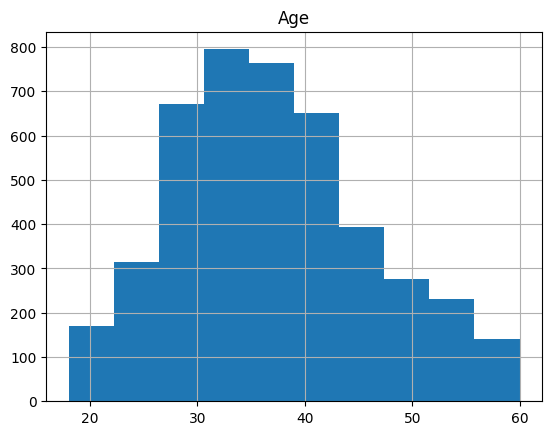

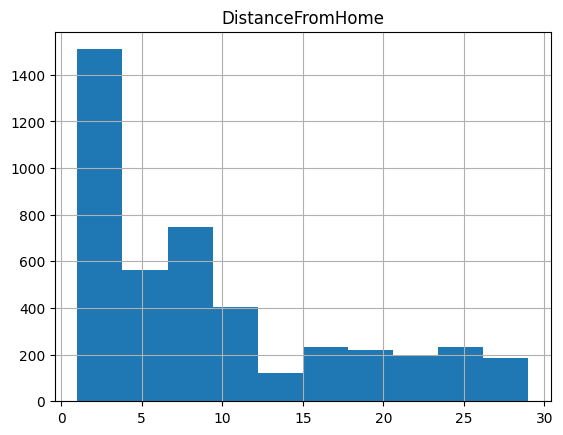

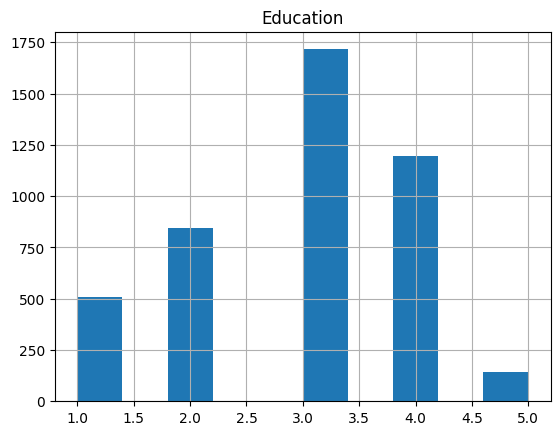

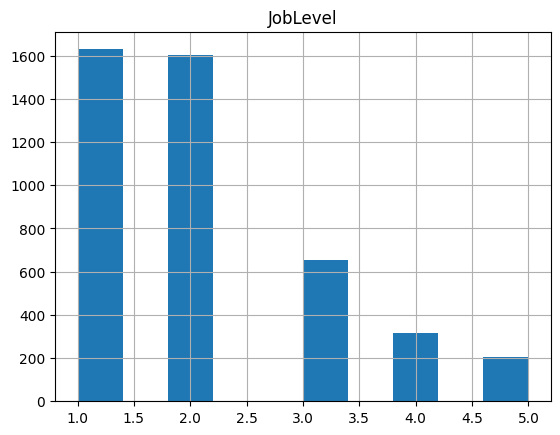

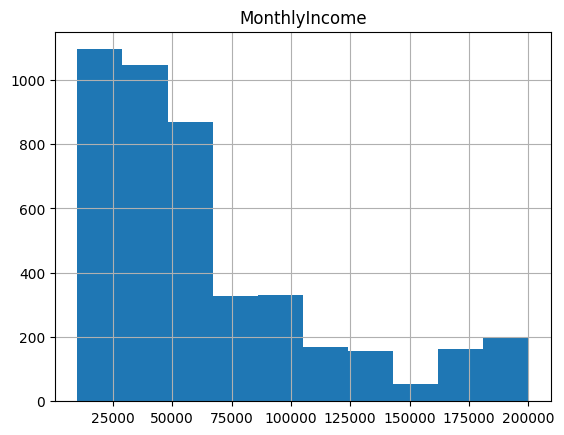

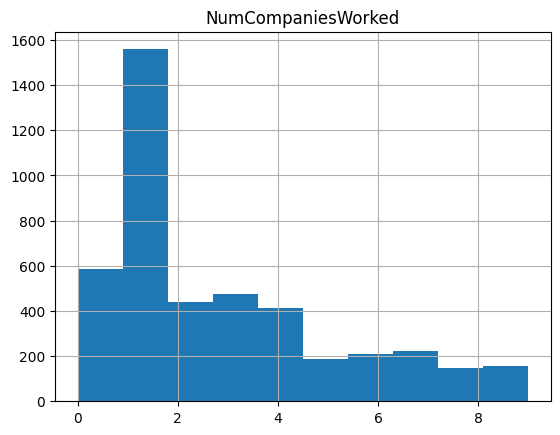

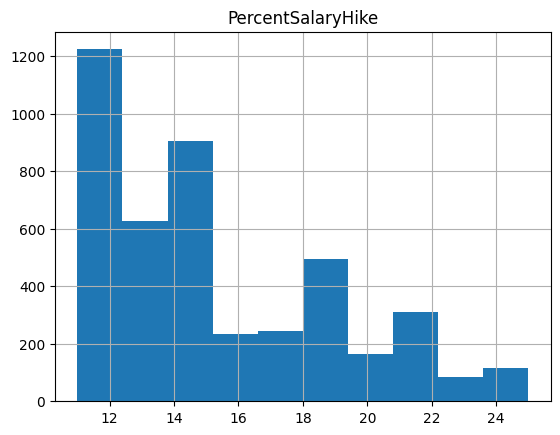

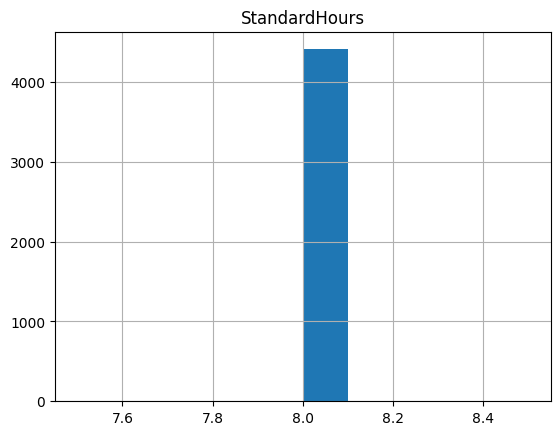

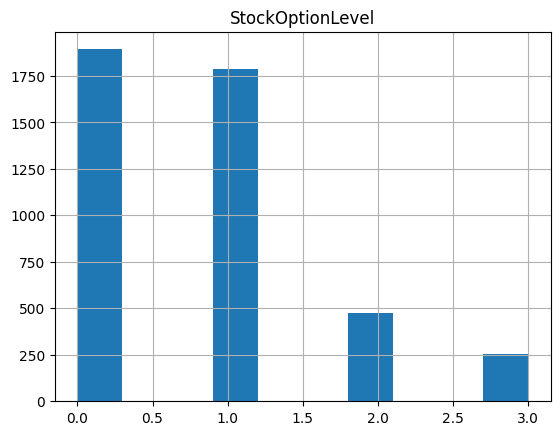

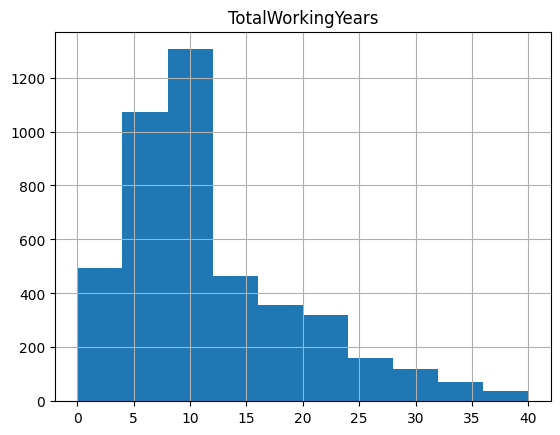

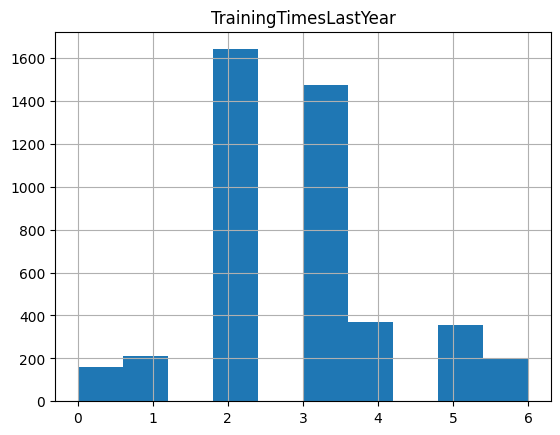

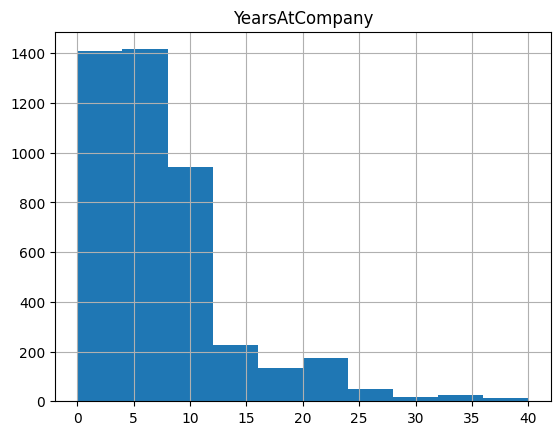

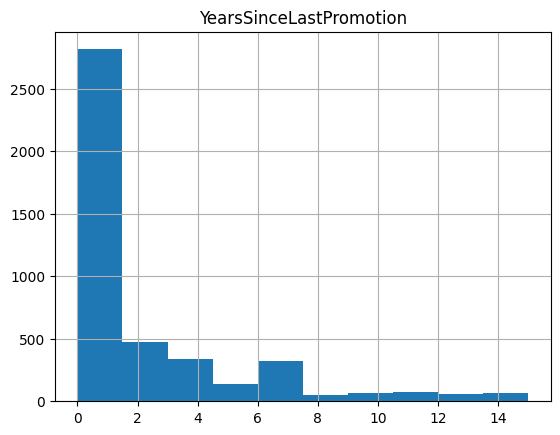

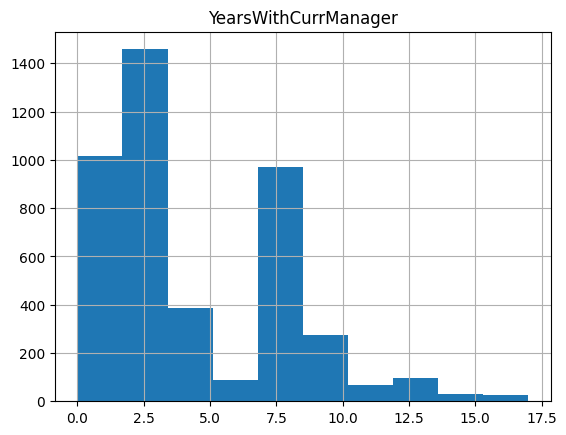

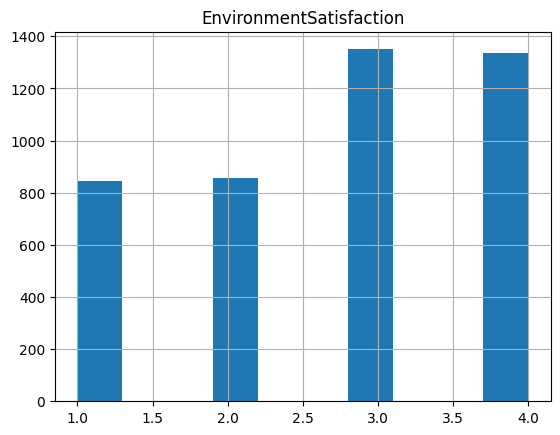

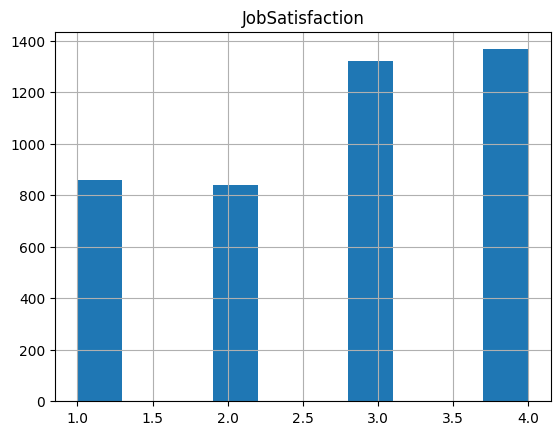

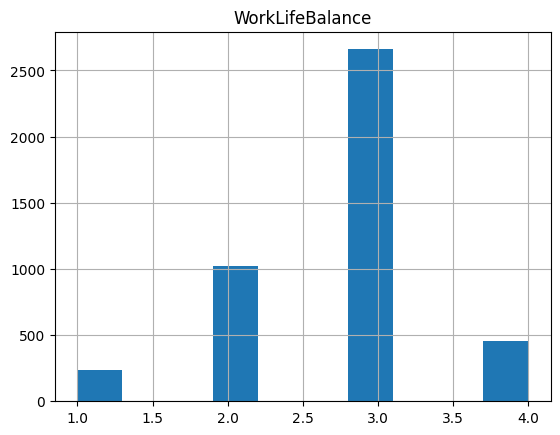

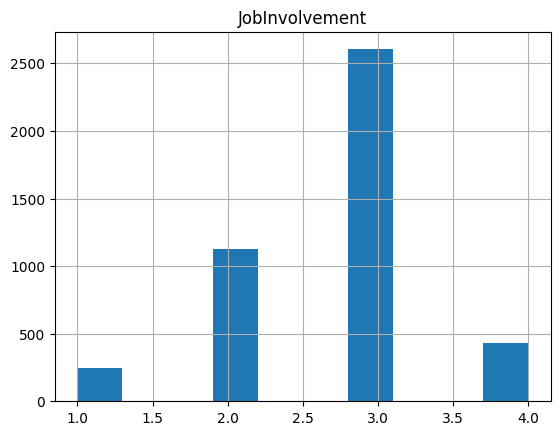

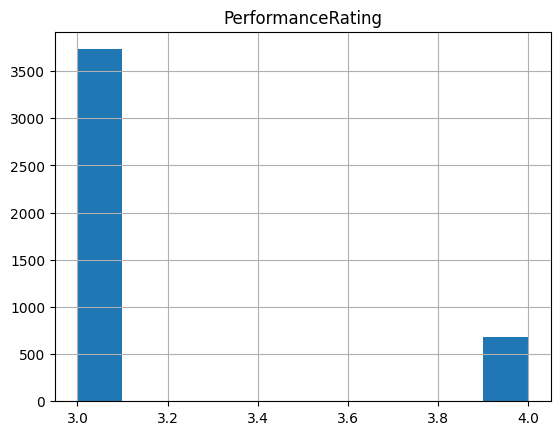

In [172]:
# Visualize distribution of numerical data before we scale it
# Visual checks are preferred as statistical tests have limitations with large datasets
# For instance Kolmogorov–Smirnov or Shapiro-Wilk tests suffer from limitations 
# in large sample sizes. Q-Q plots are another option but somewhat overkill here.

for numerical_col in numerical_cols:
    df[numerical_col].hist()
    plt.title(numerical_col)
    plt.show()

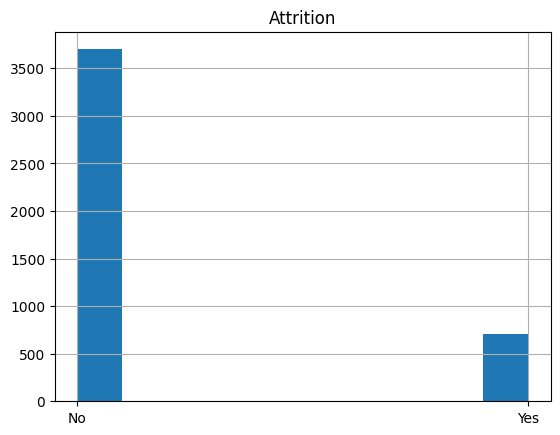

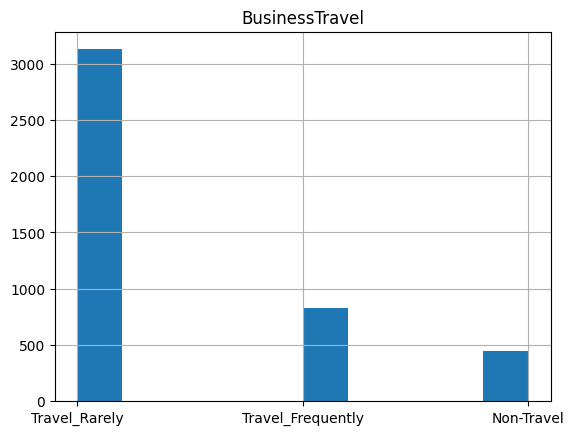

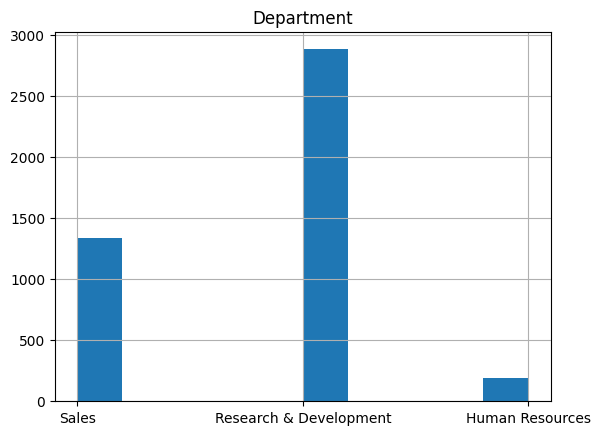

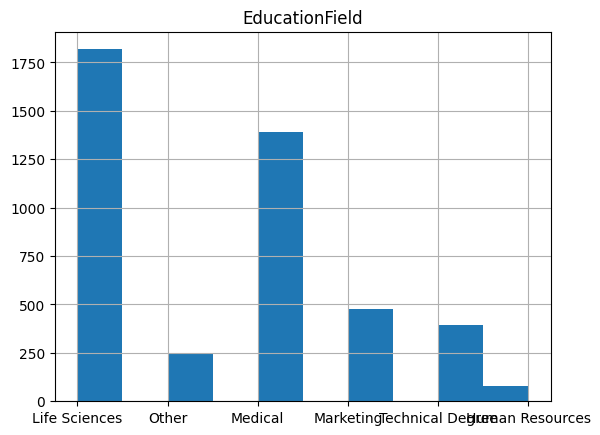

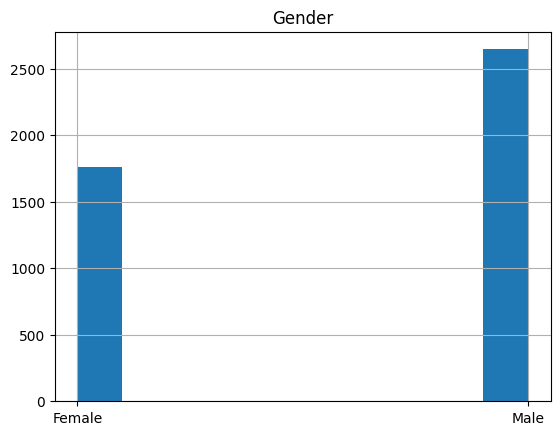

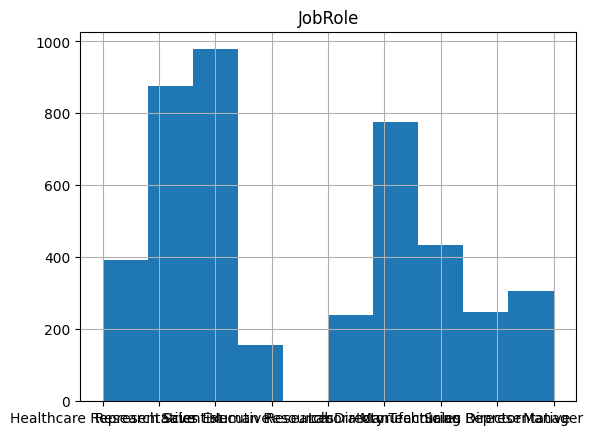

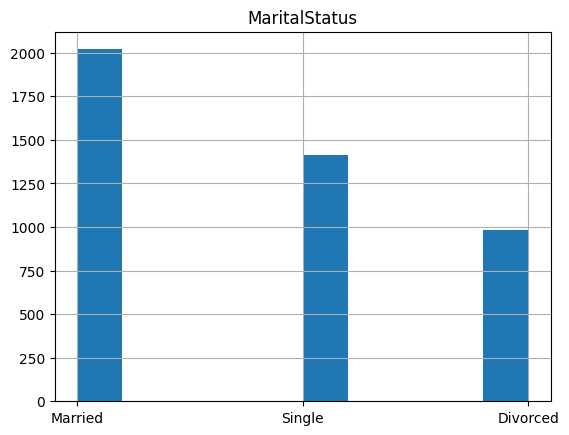

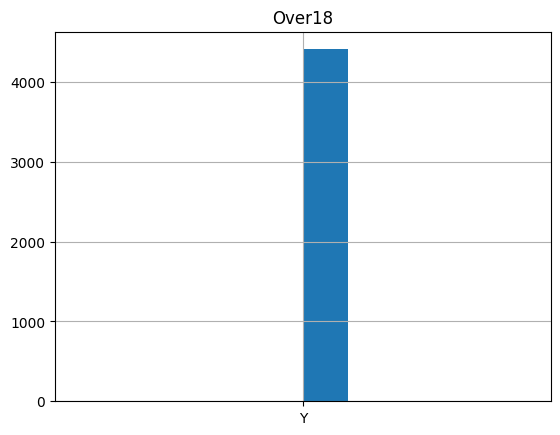

In [173]:
# Visualize distribution of categorical data before one-hot encoding
for categorical_col in categorical_cols:
    df[categorical_col].hist()
    plt.title(categorical_col)
    plt.show()

In [174]:
# Taking a look at the data frame after combining different CSVs and dropping unrelated columns 
df.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,Female,1,Healthcare Representative,...,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,1,Research Scientist,...,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,Male,4,Sales Executive,...,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,Male,3,Human Resources,...,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,Male,1,Sales Executive,...,9.0,2,6,0,4,4.0,1.0,3.0,3,3


# Data Preprocessing

In [175]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Remove 'Over18' column as it has only one unique value 'Y'
categorical_cols.remove('Over18')
df.drop(columns=['Over18'], inplace=True)

# Perform One-Hot Encoding on categorical data
ohe = OneHotEncoder(sparse_output=False)
encoded_data = ohe.fit_transform(df[categorical_cols])
df.drop(columns=categorical_cols, inplace=True)
df = pd.concat([df, pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out(categorical_cols))], axis=1)

# Separate dataframe into label and features of independent(X) and dependent(y) variables 
y = df['Attrition_Yes']
X = df.copy()
X.drop(columns=['Attrition_Yes', 'Attrition_No'], inplace=True)

# Split data into training and testing sets (2:1 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, shuffle=True, random_state=31415)

In [176]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Define columns to be scaled with StandardScaler and MinMaxScaler
normal_dist_cols = ['Age', 'Education', 'TotalWorkingYears', 'JobInvolvement', 'WorkLifeBalance', 'TrainingTimesLastYear']

non_normal_dist_cols = []
for numerical_col in numerical_cols:
    if numerical_col not in normal_dist_cols:
        non_normal_dist_cols.append(numerical_col)

# Scale data that follows normal distribution using StandardScaler (mean = 0, std = 1)
# To prevent data leakage, we fit the scalars on only the training data
ss = StandardScaler()
ss.fit(X_train[normal_dist_cols])

# Scale both training and testing data with normal distribution
X_train[normal_dist_cols] = ss.transform(X_train[normal_dist_cols])
X_test[normal_dist_cols] = ss.transform(X_test[normal_dist_cols])

#  Scale data that doesn't follow normal distribution using MinMaxScaler (min = 0, max = 1)
mms = MinMaxScaler()
mms.fit(X_train[non_normal_dist_cols])

# Scale both training and testing data with non-normal distribution
X_train[non_normal_dist_cols] = mms.transform(X_train[non_normal_dist_cols])
X_test[non_normal_dist_cols] = mms.transform(X_test[non_normal_dist_cols])

<Axes: >

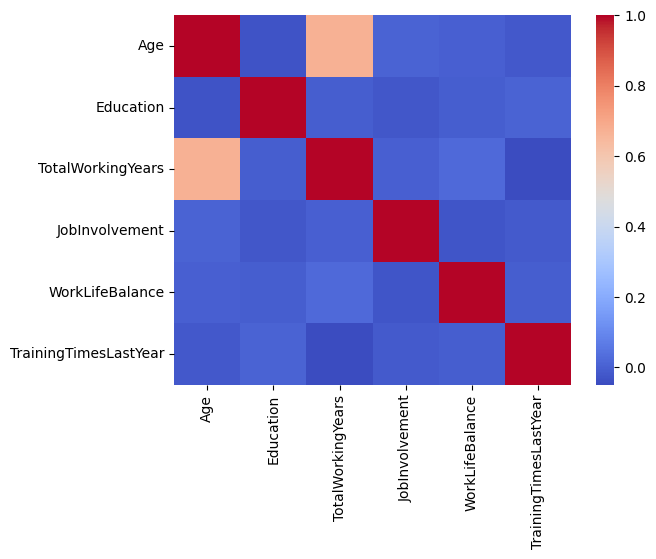

In [177]:
# Plot the covariance matrix of the normal-distribution features to ensure independence
# This method won't work for min-maxscaled values.
sns.heatmap(X_train[normal_dist_cols].cov(), cmap='coolwarm')

# Training the model

## Note
We won't perform feature selection here because our selected model, XGBoost, has the following features:

1. **L1 regularization:** By punishing the existence of non-zero weights on certain features, our model already reduces the feature space for us.
2. **Handling missing values via dropping or imputation:** XGBoost is very robust and handles missing values and performs well with skewed datasets.

## K-Fold Validation
We want to see that XGBoost can generalize across our dataset without overfitting.

In [178]:
# K-fold validation
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBClassifier

kfold = KFold(n_splits=5)

xgbc = XGBClassifier()
kf = KFold(n_splits=5, shuffle=True, random_state=31415)
cv_score = cross_val_score(estimator=xgbc, X=X_train, y=y_train,cv=kf)
print('Mean of AUCROC:', cv_score.mean(), 'Standard deviation of AUCROC:', cv_score.std())

Mean of AUCROC: 0.9615646258503402 Standard deviation of AUCROC: 0.014374521502799607


## Training larger model
Now we can train on the entire training data and see our performance for the test data

ROCAUC 0.9772180309254802


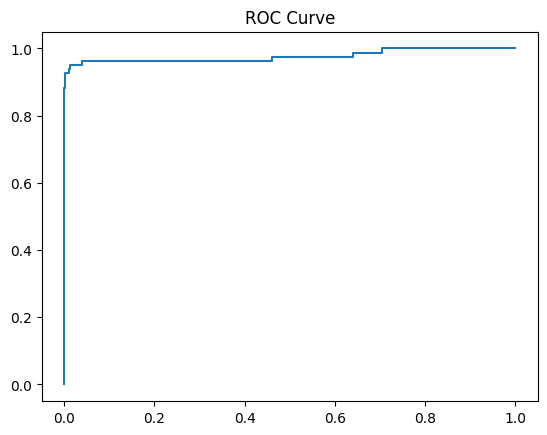

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(


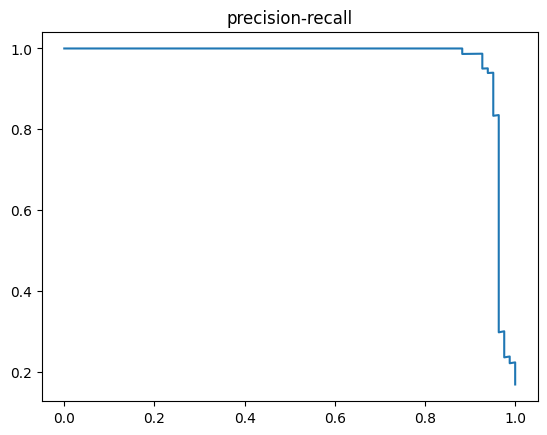

ACCURACY 0.9836734693877551


In [179]:
# Train the model using XG-Boost Classifier
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)
y_pred_prob = xgbc.predict_proba(X_test)[:, 1]
y_pred = xgbc.predict(X_test)

# Evaluate model performance on the test data using ROC-AUC, precision-recall curves, and accuracy.
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, accuracy_score

roc_auc = roc_auc_score(y_true=y_test, y_score=y_pred_prob)
print('ROCAUC', roc_auc)
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred_prob)
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.show()

precision, recall, thresholds = precision_recall_curve(y_true=y_test, probas_pred=y_pred_prob)
plt.plot(recall, precision)
plt.title("precision-recall")
plt.show()

print("ACCURACY", accuracy_score(y_test, y_pred))

# Results
A really good predictor! Accuracy of 98.37% and ROC-AUC of 0.977, not to mention a great looking precision-recall curve.

# Deploying Model

Now we train a model on all the data and save its weights. These weights will then be used at inference time on predict.py

In [180]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Now we scale on the entire dataset
ss = StandardScaler()
X[normal_dist_cols] = ss.fit_transform(X[normal_dist_cols])

mms = MinMaxScaler()
X[non_normal_dist_cols] = mms.fit_transform(X[non_normal_dist_cols])

# Now we fit XGBoost on the entire dataset
xgbc = XGBClassifier()
xgbc.fit(X, y)
xgbc.save_model('xgb_weights.json')

# Using the model
Now go to input/ and provide your own dataset! You can leave attrition as blank

In [181]:
# read data
general_data_df = pd.read_csv('./input/general_data.csv')
employee_survey_df = pd.read_csv('./input/employee_survey_data.csv')
manager_survey_df = pd.read_csv('./input/manager_survey_data.csv')

# consolidate data
combined_1 = pd.merge(general_data_df, employee_survey_df, on='EmployeeID', how='outer')
df = pd.merge(combined_1, manager_survey_df, on='EmployeeID', how='outer')

# drop unused features
employee_ids = df['EmployeeID']
df.drop(columns=['EmployeeID', 'EmployeeCount', 'Over18'], inplace=True)

# perform 1-hot encoding on categorical data
encoded_data = ohe.transform(df[categorical_cols])
df.drop(columns=categorical_cols, inplace=True)
df = pd.concat([df, pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out(categorical_cols))], axis=1)

# Get features from df
X = df.copy()
X.drop(columns=['Attrition_Yes', 'Attrition_No'], inplace=True)

# Scale our input
X[normal_dist_cols] = ss.transform(X[normal_dist_cols])
X[non_normal_dist_cols] = mms.transform(X[non_normal_dist_cols])

# perform prediction
y = xgbc.predict(X)
associated_predictions = pd.concat([employee_ids, pd.Series(y, name='Attrition').replace(1, 'Yes').replace(0, 'No')], axis=1)
associated_predictions.to_csv('predictions.csv')
print("Predictions saved to 'predictions.csv'")

Predictions saved to 'predictions.csv'
